In [163]:
from sentinelhub import SHConfig

# INSTANCE_ID = '9bf73740-000e-42a4-bf8c-58779116c642'
CLIENT_ID = '905abcbe-7def-4ad2-95ed-16d1f35b9750'
CLIENT_SECRET = 'tUVCjWN5gjTAfXsZ2uOBDZb6QL9mOTce'

config = SHConfig()

if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET

if config.sh_client_id == '' or config.sh_client_secret == '':
    print("Warning! To use Sentinel Hub services, please provide the credentials (client ID and client secret).")

config.save()

In [164]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import json

from sentinelhub import MimeType, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient, DataCollection, bbox_to_dimensions, DownloadRequest, MosaickingOrder

In [165]:
from typing import Any

def plot_image(
    image: np.ndarray, factor: float = 1.0, clip_range: tuple[float, float] | None = None, **kwargs: Any
) -> None:
    """Utility function for plotting RGB images."""
    _, ax = plt.subplots(nrows=1, ncols=1)
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

In [166]:
# bands = 12 for all bands, 2 for only B11 and B12
# mosaicking = "SIMPLE" for single image, "TILE" for multiple images metadata

def download_data(date, bbox, area_size, config, bands=12, mosaicking="SIMPLE"):
    if (bands == 12):
        bands_str = """["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B11","B12"]"""
        return_str = """sample.B01, sample.B02, sample.B03, sample.B04, sample.B05, sample.B06, sample.B07, sample.B08, sample.B8A, sample.B09, sample.B11, sample.B12"""
    elif (bands == 2):
        bands_str = """["B11","B12"]"""
        return_str = """sample.B11, sample.B12"""
    
    if(mosaicking == "SIMPLE"):
        start_date = date
        end_date = date
    elif(mosaicking == "TILE"):
        start_date = date - datetime.timedelta(days=60)
        end_date = date + datetime.timedelta(days=60)

    evalscript_all_bands = f"""
    //VERSION=3

    function setup() {{
        return {{
            input: [{{
                bands: {bands_str},
                units: "REFLECTANCE"
            }}],
            output: {{
                bands: {bands},
                sampleType: "FLOAT32"
            }},
            mosaicking: Mosaicking.{mosaicking},
            harmonize: true
        }};
    }}


    function updateOutputMetadata(scenes, inputMetadata, outputMetadata) {{
        outputMetadata.userData = {{
            "norm_factor": inputMetadata.normalizationFactors,
            "tiles": scenes.tiles
        }};
    }}


    function evaluatePixel(sample) {{
        return [{return_str}];
    }}
    """
    
    if(mosaicking == "SIMPLE"):
        response = [SentinelHubRequest.output_response("default", MimeType.TIFF),
                    SentinelHubRequest.output_response("userdata", MimeType.JSON)]
    elif(mosaicking == "TILE"):
        response = [SentinelHubRequest.output_response("userdata", MimeType.JSON)]

    request_all_bands = SentinelHubRequest(
    evalscript=evalscript_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=(start_date, end_date),
            mosaicking_order=MosaickingOrder.MOST_RECENT
        )
    ],

    responses=response,
    bbox=bbox,
    size=area_size,
    config=config,
    )

    return request_all_bands.get_data()

In [167]:
folder_path = 'EMIT_methane_data/jsons/'
json_files = [pos_json for pos_json in os.listdir(
    folder_path) if pos_json.endswith('.json')]
json_data = []
for json_file in json_files:
    with open(folder_path + json_file) as f:
        data = json.load(f)
        json_data.append(data)

print(json_data[0]['features'][0]['properties']['UTC Time Observed'])
print(json_data[0]['features'][0]['properties']
      ['Longitude of max concentration'])
print(json_data[0]['features'][0]['properties']
      ['Latitude of max concentration'])

2022-08-10T06:49:57Z
35.20281459382317
31.12788965249969


In [168]:
def get_available_dates(date, lat, lon, offset_deg=0.02/2):
    center_lat = lat
    center_lon = lon
    date = datetime.datetime.strptime(date, '%Y-%m-%dT%H:%M:%SZ')
    date = date.replace(hour=0, minute=0, second=0)

    bbox = BBox(bbox=[center_lon - offset_deg, center_lat - offset_deg,
                center_lon + offset_deg, center_lat + offset_deg], crs=CRS.WGS84)
    resolution = 20
    area_size = bbox_to_dimensions(bbox, resolution=resolution)

    all_bands_response = download_data(
        date, bbox, area_size, config, 2, "TILE")

    metadata = all_bands_response[0]['tiles']
    
    # extract dates
    dates = []
    for tile in metadata:
        dates.append(tile['date'][:10])
    # remove duplicates
    dates = list(dict.fromkeys(dates))
    return dates

In [169]:
# pick random 10 index from json_data with seed current time
import random
random.seed()

random_index = random.sample(range(len(json_data)), 10)

for i in random_index:
    date = json_data[i]['features'][0]['properties']['UTC Time Observed']
    lat = json_data[i]['features'][0]['properties']['Latitude of max concentration']
    lon = json_data[i]['features'][0]['properties']['Longitude of max concentration']
    print(date)
    dates = get_available_dates(date, lat, lon)
    print(len(dates))
    for date in dates:
        print(date)

2024-04-22T06:58:49Z


KeyboardInterrupt: 

In [ ]:
center_lat = 31.12788965249969
center_lon = 35.20281459382317
offset_deg = 0.02/2

date = datetime.datetime(2022, 7, 10, 0, 0, 0)

bbox = BBox(bbox=[center_lon - offset_deg, center_lat - offset_deg, center_lon + offset_deg, center_lat + offset_deg], crs=CRS.WGS84)

resolution = 20
area_size = bbox_to_dimensions(bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {area_size} pixels")

Image shape at 20 m resolution: (93, 113) pixels


In [ ]:
available_dates = get_available_dates(date.strftime('%Y-%m-%dT%H:%M:%SZ'), center_lat, center_lon)

print(len(available_dates))

4


In [ ]:
start_date = available_dates[len(available_dates) - 1][:10]
end_date = available_dates[0][:10]
folder_name = f"./data/{start_date}_{end_date}" # folder name is start-date_end-date
os.makedirs(folder_name, exist_ok=True)

for date in available_dates:
    all_bands_response = download_data(date, bbox, area_size, config, 2, "SIMPLE") # download B11 and B12 bands
    image_data = all_bands_response[0]['default.tif']
    json_data = all_bands_response[0]['userdata.json']['tiles'][0]
    json_data['dimensions'] = image_data.shape
    json_data['bounding_box'] = {
        "min_lat": center_lat - offset_deg,
        "max_lat": center_lat + offset_deg,
        "min_lon": center_lon - offset_deg,
        "max_lon": center_lon + offset_deg
    }
    print(f"Downloaded data for {date}")

    curr_date = date[:10]
    np.save(f"{folder_name}/{curr_date}.npy", image_data)
    with open(f"{folder_name}/{curr_date}.json", "w") as f:
        json.dump(json_data, f)

2022-07-19
Downloaded data for 2022-07-19
2022-07-14
Downloaded data for 2022-07-14
2022-07-09
Downloaded data for 2022-07-09
2022-07-04
Downloaded data for 2022-07-04


shape:  (113, 93, 2)
{'shId': 21257003, 'cloudCoverage': 0.01, 'date': '2022-07-04T08:31:44Z', 'tileOriginalId': 'S2A_OPER_MSI_L2A_TL_ATOS_20220704T120921_A036726_T36RXV_N04.00', 'dataPath': 's3://sentinel-s2-l2a/tiles/36/R/XV/2022/7/4/0', 'productId': 'S2A_MSIL2A_20220704T081621_N0400_R121_T36RXV_20220704T120921', 'dimensions': [113, 93, 2], 'bounding_box': {'min_lat': 31.117889652499688, 'max_lat': 31.13788965249969, 'min_lon': 35.19281459382317, 'max_lon': 35.21281459382317}}


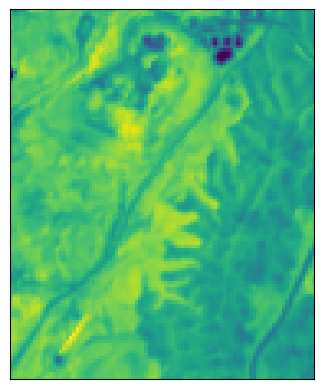

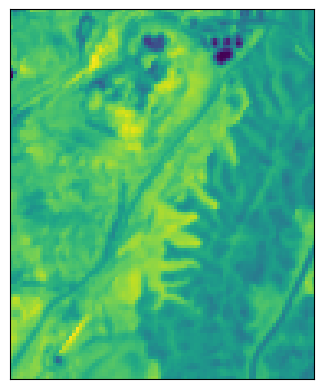

In [ ]:
# traverse the 'folder_name', get the first image and plot it
for file in os.listdir(folder_name):
    if file.endswith('.npy'):
        image = np.load(f"{folder_name}/{file}")
        print('shape: ', image.shape)
        plot_image(image[:, :, 0]) # B11
        plot_image(image[:, :, 1]) # B12

        # open corresponding json file to get metadata
        with open(f"{folder_name}/{file[:-4]}.json") as f:
            metadata = json.load(f)
            print(metadata)

        break